In [33]:
import cv2
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt


In [34]:
IMAGE_DIR = "/data2/SrikanthData/ResearchWork2/tensorflow/Project/img_data/d1/Images"
MASK_DIR = "/data2/SrikanthData/ResearchWork2/tensorflow/Project/img_data/d1/Mask_cup"
BATCH_SIZE = 4

In [35]:
def double_conv_block(x, n_filters):
    # Conv2D then ReLU activation
    x = tf.keras.layers.Conv2D(
        n_filters,
        3,
        padding="same",
        activation="relu",
        kernel_initializer="he_normal"
    )(x)
    # Conv2D then ReLU activation
    x = tf.keras.layers.Conv2D(
        n_filters,
        3,
        padding="same",
        activation="relu",
        kernel_initializer="he_normal"
    )(x)
    return x

def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = tf.keras.layers.MaxPool2D(2)(f)
    p = tf.keras.layers.Dropout(0.3)(p)
    return f, p

def upsample_block(x, conv_features, n_filters):
    # upsample
    x = tf.keras.layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    # concatenate
    x = tf.keras.layers.concatenate([x, conv_features])
    # dropout
    x = tf.keras.layers.Dropout(0.3)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)
    return x

def create_unet():
    # inputs
    inputs = tf.keras.layers.Input(shape=(128,128,3))
    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 32) # 64
    # 2 - downsample
    f2, p2 = downsample_block(p1, 64) # 128
    # 3 - downsample
    f3, p3 = downsample_block(p2, 128) # 256
    # 4 - downsample
    f4, p4 = downsample_block(p3, 256) # 512
    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 256) # 1024

    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 256) # 512
    # 7 - upsample
    u7 = upsample_block(u6, f3, 128) # 256
    # 8 - upsample
    u8 = upsample_block(u7, f2, 64) # 128
    # 9 - upsample
    u9 = upsample_block(u8, f1, 32)
    # outputs
    outputs = tf.keras.layers.Conv2D(1, 1, padding="same", activation = "sigmoid")(u9)
    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
    return unet_model



In [36]:
# load data
assert len(os.listdir(IMAGE_DIR)) == len(os.listdir(MASK_DIR)), "Different number of images and masks"
X, Y, file_names = [], [], []
for image_name in sorted(os.listdir(IMAGE_DIR)):
    mask_name = image_name[:-4] + "_cupsegSoftmap.png"
    

    image = cv2.imread(os.path.join(IMAGE_DIR, image_name))
    image = cv2.resize(image, (256, 256))
    

    mask = cv2.imread(os.path.join(MASK_DIR, mask_name))
    mask = cv2.resize(mask, (256, 256))


    X.append(image)
    Y.append(mask)
    file_names.append(image_name)


In [37]:
def dice_coef(y_true, y_pred): # accuracy function 
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + 1e-6) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + 1e-6)
  
def dice_loss(y_true,y_pred): # loss function 
    return -dice_coef(y_true,y_pred)
  
def log_dice_loss(y_true, y_pred):
    return -tf.math.log(dice_coef(y_true, y_pred))



def iou(y_true, y_pred, threshold=0.5):                                                             
    y_true = tf.reshape(y_true, [-1])                                                               
    y_true = tf.cast(y_true, tf.float32)                                                            
    y_pred = tf.cast(y_pred > threshold, tf.float32)                                                
                                                                                                    
    y_pred = tf.reshape(y_pred, [-1])                                                               
                                                                                                    
                                                                                                    
    intersection = tf.reduce_sum(y_true*y_pred)                                                     
    union = tf.reduce_sum(tf.cast(y_true + y_pred > 0, tf.float32))                                 
                                                                                                    
    return intersection/union 

In [38]:
def augmentation_fn(image, mask, training=True):
    """
    Augmentation for training set only. random cropy 50% of the time, random flip 50% of the time
    """
    # change brightness

    image = image.copy()
    mask = mask.copy()
    if training:
        image = tf.image.random_brightness(image, 0.1)
        image = tf.image.random_hue(image, 0.1)
    
        seed = np.random.randint(0, 1000, (2, ))
        if np.random.rand() < 0.5:
            random_size = np.random.randint(210, 256) # this is because the size of the image is 256 
        
            image = tf.image.stateless_random_crop(image, [random_size, random_size, 3], seed=seed)
            mask = tf.image.stateless_random_crop(mask, [random_size, random_size, 3], seed=seed)

        if np.random.rand() < 0.5:
            image = tf.image.stateless_random_flip_up_down(image, seed)
            mask = tf.image.stateless_random_flip_up_down(mask, seed)


    image = tf.image.resize(image, (128, 128))/122.5 - 1.0
    mask = tf.cast(tf.image.resize(mask, (128, 128)) > 122.5, float)[:, :, :1]
    
    return image, mask



In [39]:
# Split train and test
mask = list(range(len(X)))
np.random.seed(0)
np.random.shuffle(mask)
n_train = int(0.8*len(mask))
X_train = [X[i] for i in mask[:n_train]]
Y_train = [Y[i] for i in mask[:n_train]]
name_train = [file_names[i] for i in mask[:n_train]]

X_test = [X[i] for i in mask[n_train:]]
Y_test = [Y[i] for i in mask[n_train:]]
name_test = [file_names[i] for i in mask[n_train:]]

def data_generator(X, Y, batch_size=BATCH_SIZE, training=True):
    n_data = len(X)

    i = 0
    while True:
        if i + batch_size > n_data:
            i = 0
            mask = np.arange(n_data)
            np.random.shuffle(mask)

            X = [X[j] for j in mask]
            Y = [Y[j] for j in mask]
        
        mini_X = X[i: i + batch_size] 
        mini_Y = Y[i: i + batch_size]

        
        processed_data = [augmentation_fn(x, y, training) for x, y in zip(mini_X, mini_Y)]
        mini_X = [item[0] for item in processed_data]
        mini_Y = [item[1] for item in processed_data]


        mini_X = tf.concat([tf.expand_dims(_, axis=0) for _ in mini_X], axis=0)
        mini_Y = tf.concat([tf.expand_dims(_, axis=0) for _ in mini_Y], axis=0)

        i += batch_size
        yield mini_X, mini_Y



In [41]:
model = create_unet()

model.summary()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=log_dice_loss,
    metrics=[dice_coef, iou]
)

train_generator = data_generator(X_train, Y_train, training=True)
validation_generator = data_generator(X_test, Y_test, training=False)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
history = model.fit(
    train_generator,
    epochs=300,
    validation_data=validation_generator,
    steps_per_epoch=len(X_train)//BATCH_SIZE,
    validation_steps=len(X_test)//BATCH_SIZE,
    callbacks=[early_stopping]
)

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 128, 128, 32  896         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_39 (Conv2D)             (None, 128, 128, 32  9248        ['conv2d_38[0][0]']              
                                )                                                             

 nspose)                        )                                                                 
                                                                                                  
 concatenate_11 (Concatenate)   (None, 128, 128, 64  0           ['conv2d_transpose_11[0][0]',    
                                )                                 'conv2d_39[0][0]']              
                                                                                                  
 dropout_23 (Dropout)           (None, 128, 128, 64  0           ['concatenate_11[0][0]']         
                                )                                                                 
                                                                                                  
 conv2d_54 (Conv2D)             (None, 128, 128, 32  18464       ['dropout_23[0][0]']             
                                )                                                                 
          

2023-04-24 16:41:10.015349: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inU-Net/dropout_16/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


20/20 [==============================] - 6s 55ms/step - loss: 3.1186 - dice_coef: 0.0458 - iou: 0.0213 - val_loss: 2.9959 - val_dice_coef: 0.0516 - val_iou: 0.1664
Epoch 2/300
20/20 [==============================] - 1s 37ms/step - loss: 2.2840 - dice_coef: 0.1141 - iou: 0.1539 - val_loss: 1.1121 - val_dice_coef: 0.3319 - val_iou: 0.4343
Epoch 3/300
20/20 [==============================] - 1s 37ms/step - loss: 1.1239 - dice_coef: 0.3614 - iou: 0.2972 - val_loss: 0.7883 - val_dice_coef: 0.4943 - val_iou: 0.3874
Epoch 4/300
20/20 [==============================] - 1s 38ms/step - loss: 0.5045 - dice_coef: 0.6174 - iou: 0.4890 - val_loss: 0.4748 - val_dice_coef: 0.6434 - val_iou: 0.5207
Epoch 5/300
20/20 [==============================] - 1s 38ms/step - loss: 0.5317 - dice_coef: 0.6084 - iou: 0.4647 - val_loss: 0.3600 - val_dice_coef: 0.7005 - val_iou: 0.5610
Epoch 6/300
20/20 [==============================] - 1s 36ms/step - loss: 0.3658 - dice_coef: 0.7024 - iou: 0.5635 - val_loss: 0.464

20/20 [==============================] - 1s 36ms/step - loss: 0.1837 - dice_coef: 0.8346 - iou: 0.7209 - val_loss: 0.2315 - val_dice_coef: 0.7938 - val_iou: 0.6609
Epoch 48/300
20/20 [==============================] - 1s 34ms/step - loss: 0.1795 - dice_coef: 0.8385 - iou: 0.7280 - val_loss: 0.2807 - val_dice_coef: 0.7563 - val_iou: 0.6113
Epoch 49/300
20/20 [==============================] - 1s 38ms/step - loss: 0.1890 - dice_coef: 0.8318 - iou: 0.7203 - val_loss: 0.1891 - val_dice_coef: 0.8286 - val_iou: 0.7113
Epoch 50/300
20/20 [==============================] - 1s 38ms/step - loss: 0.1924 - dice_coef: 0.8266 - iou: 0.7085 - val_loss: 0.3791 - val_dice_coef: 0.7002 - val_iou: 0.5590
Epoch 51/300
20/20 [==============================] - 1s 38ms/step - loss: 0.1971 - dice_coef: 0.8222 - iou: 0.7008 - val_loss: 0.2877 - val_dice_coef: 0.7596 - val_iou: 0.6287
Epoch 52/300
20/20 [==============================] - 1s 35ms/step - loss: 0.1783 - dice_coef: 0.8378 - iou: 0.7241 - val_loss: 

20/20 [==============================] - 1s 37ms/step - loss: 0.1517 - dice_coef: 0.8605 - iou: 0.7584 - val_loss: 0.1730 - val_dice_coef: 0.8417 - val_iou: 0.7288
Epoch 94/300
20/20 [==============================] - 1s 36ms/step - loss: 0.1566 - dice_coef: 0.8568 - iou: 0.7536 - val_loss: 0.1994 - val_dice_coef: 0.8233 - val_iou: 0.7082
Epoch 95/300
20/20 [==============================] - 1s 35ms/step - loss: 0.1515 - dice_coef: 0.8602 - iou: 0.7579 - val_loss: 0.1684 - val_dice_coef: 0.8461 - val_iou: 0.7365
Epoch 96/300
20/20 [==============================] - 1s 36ms/step - loss: 0.1537 - dice_coef: 0.8587 - iou: 0.7557 - val_loss: 0.1883 - val_dice_coef: 0.8293 - val_iou: 0.7120
Epoch 97/300
20/20 [==============================] - 1s 37ms/step - loss: 0.1814 - dice_coef: 0.8356 - iou: 0.7214 - val_loss: 0.1835 - val_dice_coef: 0.8328 - val_iou: 0.7158
Epoch 98/300
20/20 [==============================] - 1s 35ms/step - loss: 0.1679 - dice_coef: 0.8469 - iou: 0.7381 - val_loss: 

20/20 [==============================] - 1s 37ms/step - loss: 0.1391 - dice_coef: 0.8711 - iou: 0.7743 - val_loss: 0.1694 - val_dice_coef: 0.8457 - val_iou: 0.7370
Epoch 140/300
20/20 [==============================] - 1s 36ms/step - loss: 0.1423 - dice_coef: 0.8684 - iou: 0.7699 - val_loss: 0.1844 - val_dice_coef: 0.8332 - val_iou: 0.7176
Epoch 141/300
20/20 [==============================] - 1s 35ms/step - loss: 0.1369 - dice_coef: 0.8734 - iou: 0.7789 - val_loss: 0.1823 - val_dice_coef: 0.8352 - val_iou: 0.7202
Epoch 142/300
20/20 [==============================] - 1s 37ms/step - loss: 0.1206 - dice_coef: 0.8873 - iou: 0.8002 - val_loss: 0.1696 - val_dice_coef: 0.8449 - val_iou: 0.7357
Epoch 143/300
20/20 [==============================] - 1s 35ms/step - loss: 0.1309 - dice_coef: 0.8783 - iou: 0.7862 - val_loss: 0.1880 - val_dice_coef: 0.8298 - val_iou: 0.7133
Epoch 144/300
20/20 [==============================] - 1s 39ms/step - loss: 0.1215 - dice_coef: 0.8863 - iou: 0.7988 - val_l

20/20 [==============================] - 1s 37ms/step - loss: 0.1150 - dice_coef: 0.8928 - iou: 0.8097 - val_loss: 0.1581 - val_dice_coef: 0.8549 - val_iou: 0.7496
Epoch 186/300
20/20 [==============================] - 1s 35ms/step - loss: 0.1093 - dice_coef: 0.8971 - iou: 0.8156 - val_loss: 0.1545 - val_dice_coef: 0.8590 - val_iou: 0.7577
Epoch 187/300
20/20 [==============================] - 1s 36ms/step - loss: 0.1135 - dice_coef: 0.8933 - iou: 0.8096 - val_loss: 0.1591 - val_dice_coef: 0.8534 - val_iou: 0.7456
Epoch 188/300
20/20 [==============================] - 1s 37ms/step - loss: 0.1153 - dice_coef: 0.8917 - iou: 0.8062 - val_loss: 0.2133 - val_dice_coef: 0.8103 - val_iou: 0.6860
Epoch 189/300
20/20 [==============================] - 1s 36ms/step - loss: 0.1177 - dice_coef: 0.8898 - iou: 0.8032 - val_loss: 0.1560 - val_dice_coef: 0.8597 - val_iou: 0.7632
Epoch 190/300
20/20 [==============================] - 1s 36ms/step - loss: 0.1166 - dice_coef: 0.8908 - iou: 0.8055 - val_l

20/20 [==============================] - 1s 36ms/step - loss: 0.0977 - dice_coef: 0.9075 - iou: 0.8318 - val_loss: 0.1691 - val_dice_coef: 0.8456 - val_iou: 0.7349
Epoch 232/300
20/20 [==============================] - 1s 35ms/step - loss: 0.1057 - dice_coef: 0.9003 - iou: 0.8207 - val_loss: 0.1874 - val_dice_coef: 0.8303 - val_iou: 0.7126
Epoch 233/300
20/20 [==============================] - 1s 37ms/step - loss: 0.1032 - dice_coef: 0.9024 - iou: 0.8235 - val_loss: 0.1633 - val_dice_coef: 0.8497 - val_iou: 0.7399
Epoch 234/300
20/20 [==============================] - 1s 36ms/step - loss: 0.1035 - dice_coef: 0.9022 - iou: 0.8232 - val_loss: 0.1561 - val_dice_coef: 0.8577 - val_iou: 0.7555
Epoch 235/300
20/20 [==============================] - 1s 38ms/step - loss: 0.1000 - dice_coef: 0.9054 - iou: 0.8287 - val_loss: 0.1580 - val_dice_coef: 0.8539 - val_iou: 0.7454
Epoch 236/300
20/20 [==============================] - 1s 35ms/step - loss: 0.1071 - dice_coef: 0.8993 - iou: 0.8197 - val_l

20/20 [==============================] - 1s 35ms/step - loss: 0.0925 - dice_coef: 0.9121 - iou: 0.8398 - val_loss: 0.1643 - val_dice_coef: 0.8497 - val_iou: 0.7420
Epoch 278/300
20/20 [==============================] - 1s 34ms/step - loss: 0.0881 - dice_coef: 0.9160 - iou: 0.8461 - val_loss: 0.1992 - val_dice_coef: 0.8202 - val_iou: 0.6971
Epoch 279/300
20/20 [==============================] - 1s 35ms/step - loss: 0.0857 - dice_coef: 0.9181 - iou: 0.8492 - val_loss: 0.1659 - val_dice_coef: 0.8478 - val_iou: 0.7386
Epoch 280/300
20/20 [==============================] - 1s 35ms/step - loss: 0.0794 - dice_coef: 0.9240 - iou: 0.8603 - val_loss: 0.1881 - val_dice_coef: 0.8297 - val_iou: 0.7104
Epoch 281/300
20/20 [==============================] - 1s 35ms/step - loss: 0.0818 - dice_coef: 0.9219 - iou: 0.8565 - val_loss: 0.1705 - val_dice_coef: 0.8435 - val_iou: 0.7316
Epoch 282/300
20/20 [==============================] - 1s 35ms/step - loss: 0.0856 - dice_coef: 0.9183 - iou: 0.8501 - val_l

In [42]:
best_epoch = np.argmin(history.history["val_loss"])
print("Best Validation Loss: ", history.history["val_loss"][best_epoch])
print("Best Dice Coffecient (F1): ", history.history["val_dice_coef"][best_epoch])
print("Best IoU (Jaccard): ", history.history["val_iou"][best_epoch])


Best Validation Loss:  0.12119658291339874
Best Dice Coffecient (F1):  0.8860596418380737
Best IoU (Jaccard):  0.796586811542511


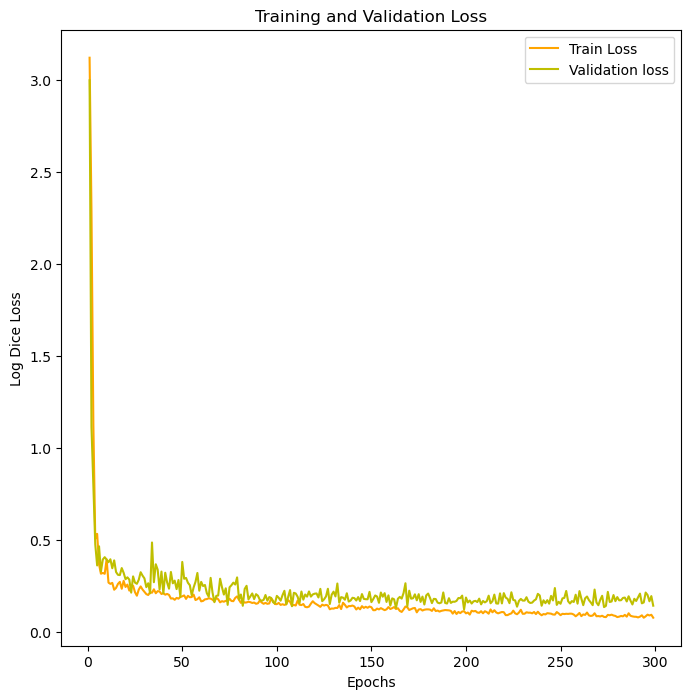

In [56]:
t_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.figure(figsize=(8, 8))
plt.plot(epochs, t_loss, 'orange', label='Train Loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Log Dice Loss')
# plt.grid()
plt.legend()

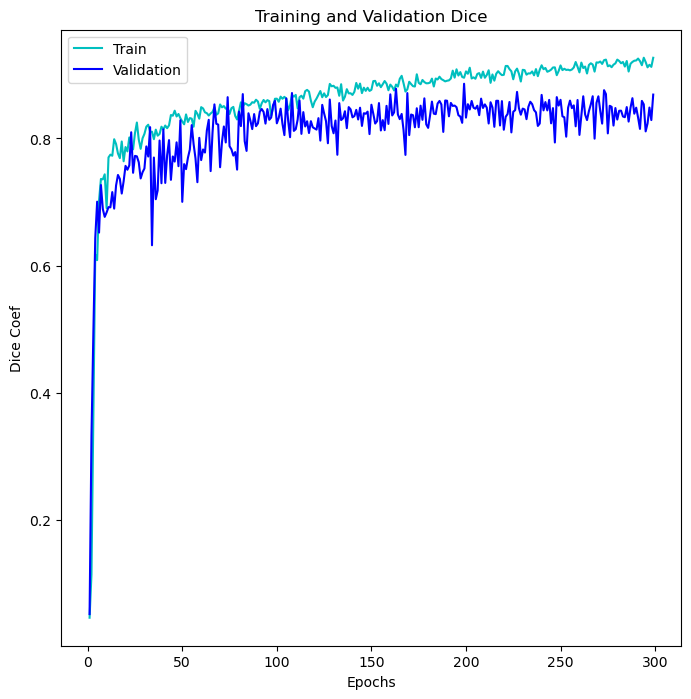

In [57]:
loss = history.history['loss']
acc=history.history['dice_coef']
val_acc=history.history['val_dice_coef']
epochs = range(1, len(acc) + 1)
plt.figure(figsize=(8, 8))
plt.plot(epochs, acc, 'c', label='Train')
plt.plot(epochs, val_acc, 'b', label='Validation')
plt.title('Training and Validation Dice')
plt.xlabel('Epochs')
plt.ylabel('Dice Coef')
# plt.grid()
plt.legend()

In [11]:
from skimage.morphology import dilation
from skimage.feature import canny
from skimage import color

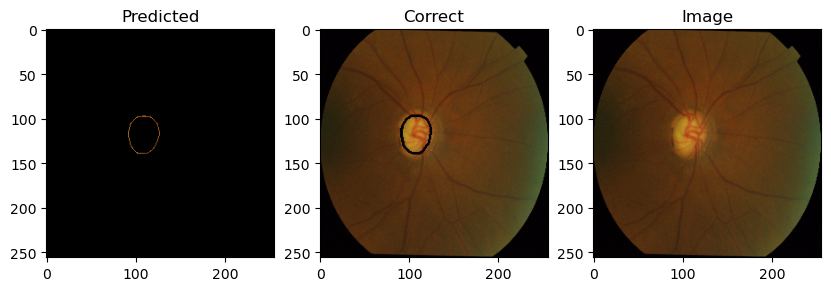

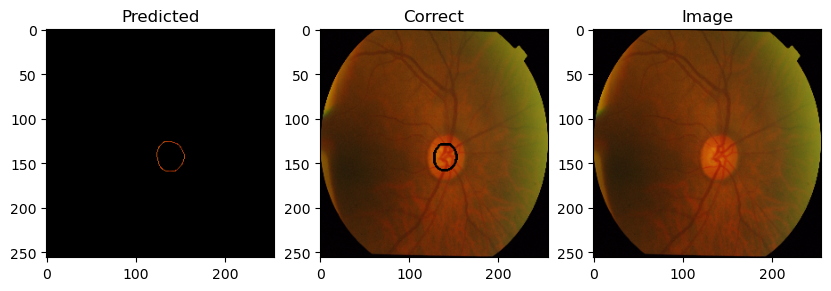

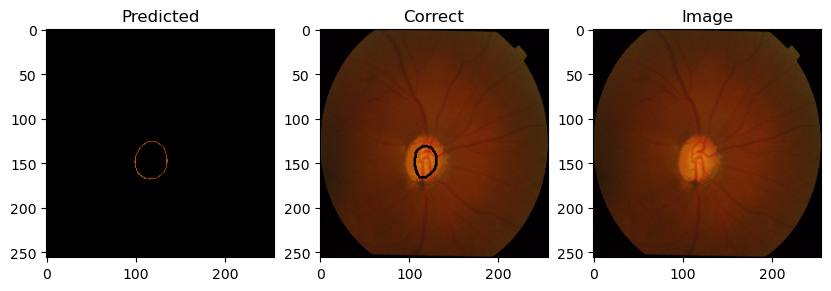

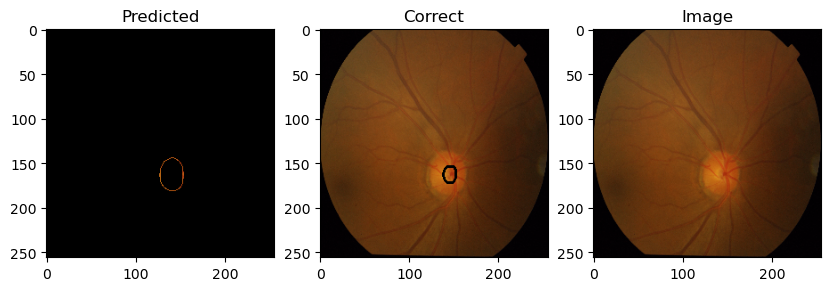

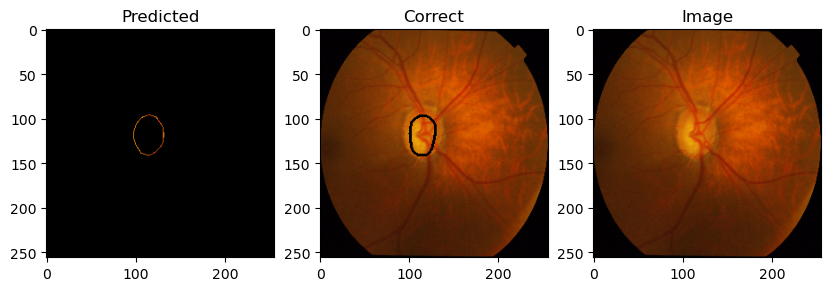

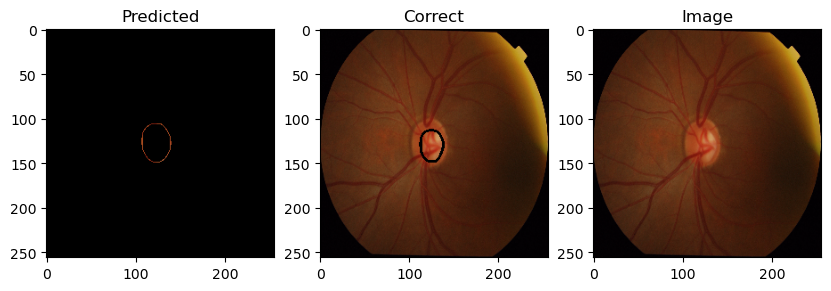

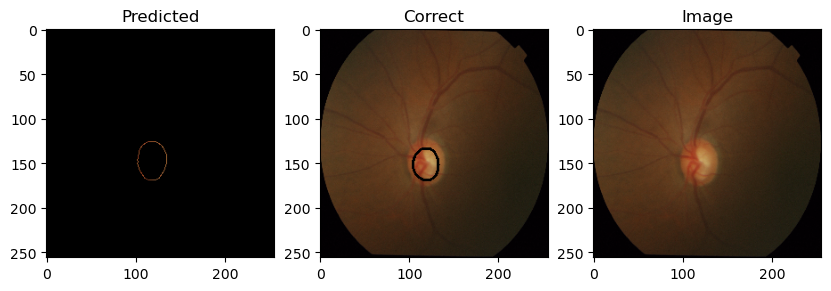

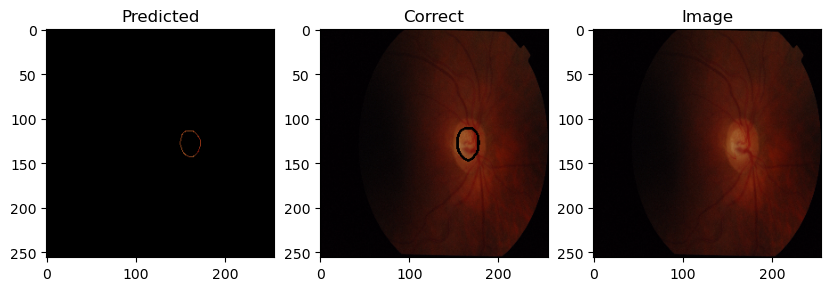

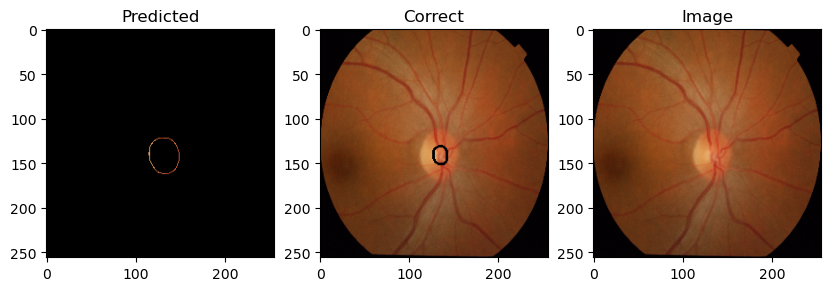

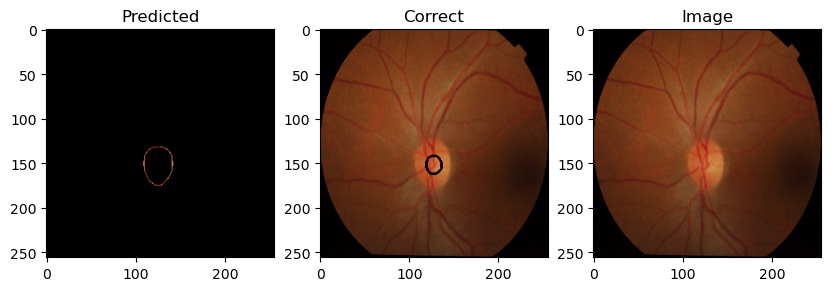

In [19]:
for image , mask, file_name in zip(X_test[: 10], Y_test[:10], name_test[:10]):

    x_test = image.copy()
    x_test = tf.image.resize(x_test, (128, 128))/122.5 - 1.0

    mask = (mask[:, :, 0] > 225.5) + 0.0
    

    pred = (model.predict(tf.expand_dims(x_test, axis=0), verbose=0)[0] > 0.5).astype(float)
    pred = cv2.resize(pred, (256, 256))

    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(1, 3, 1)
    ax.set_title('Predicted')
    edgesp = canny(pred)
#     edgesp = 1.0-dilation(edgesp)
    edgesp = color.gray2rgb(1.0*edgesp)
    ax.imshow((image*edgesp).astype(int)[:, :, ::-1])


    ax = fig.add_subplot(1, 3, 2)
    ax.set_title('Correct')
    edgesc = canny(mask)
    edgesc = 1.0-dilation(edgesc)
    edgesc = color.gray2rgb(1.0*edgesc)
    ax.imshow((image*edgesc).astype(int)[:, :, ::-1])

    ax = fig.add_subplot(1, 3, 3)
    ax.set_title('Image')
    ax.imshow(image[:, :, ::-1])

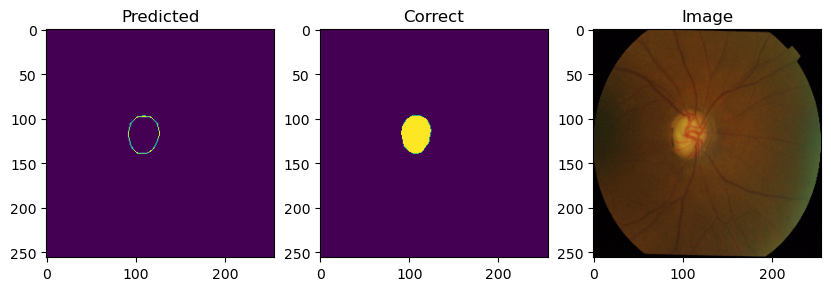

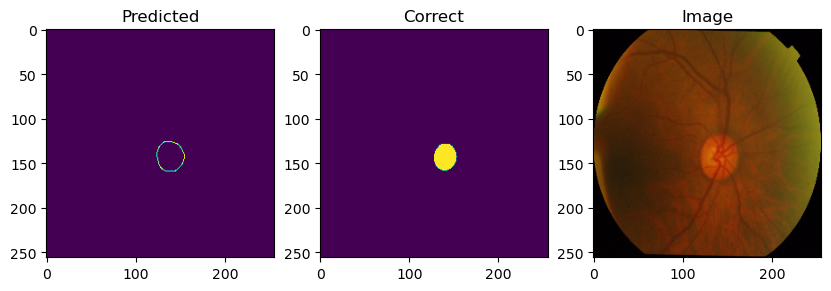

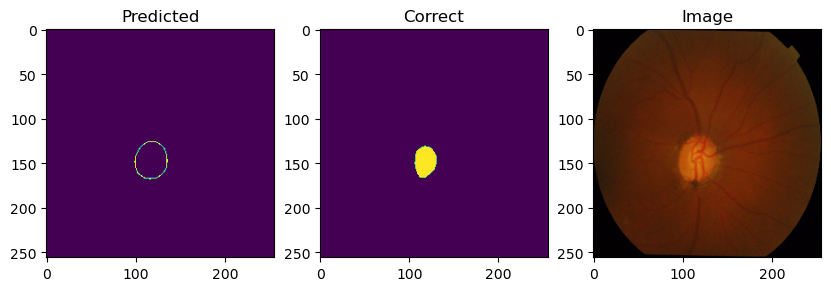

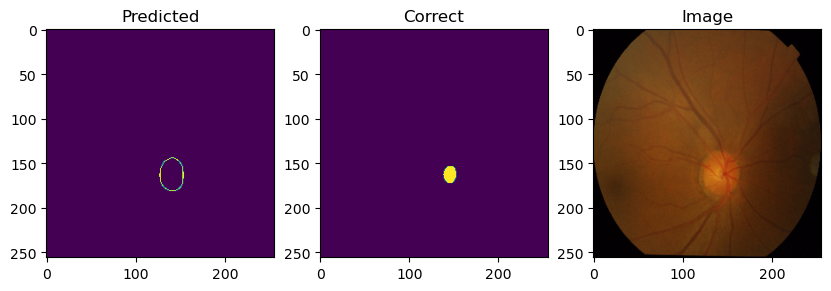

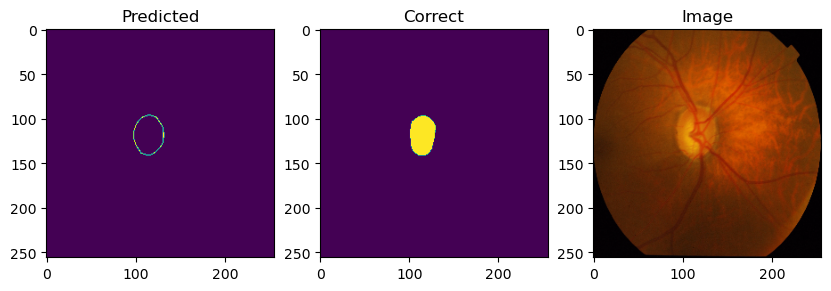

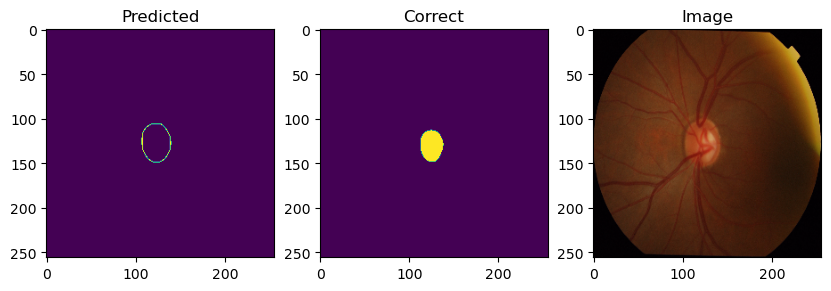

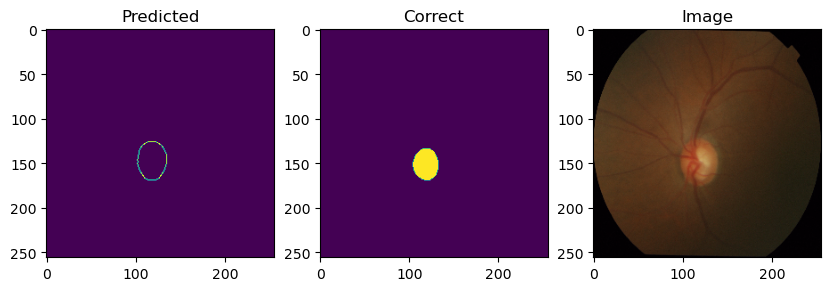

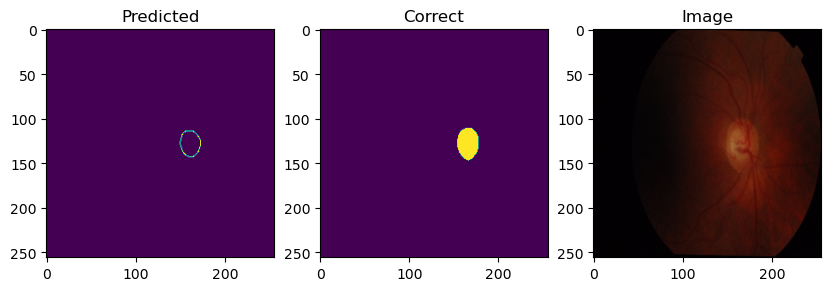

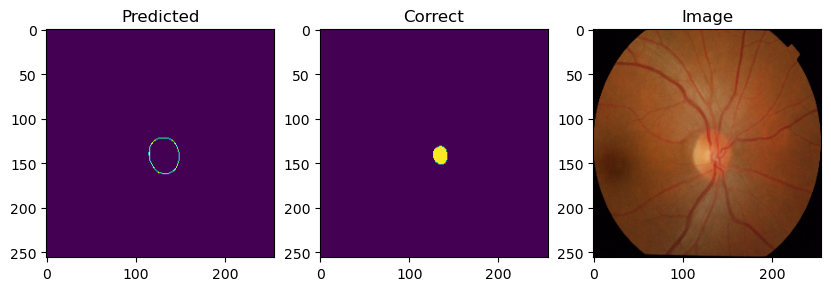

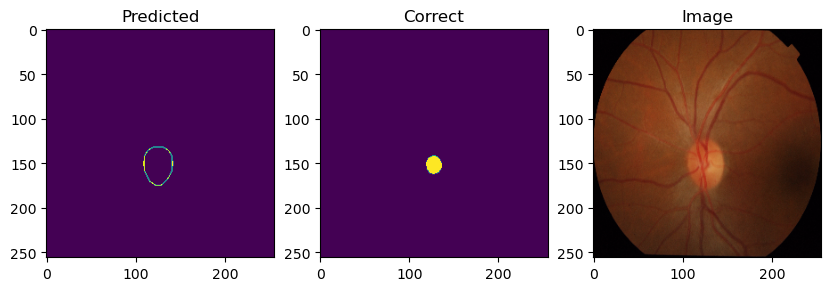

In [21]:
for image , mask, file_name in zip(X_test[: 10], Y_test[:10], name_test[:10]):

    x_test = image.copy()
    x_test = tf.image.resize(x_test, (128, 128))/122.5 - 1.0

    mask = (mask[:, :, 0] > 225.5) + 0.0
    

    pred = (model.predict(tf.expand_dims(x_test, axis=0), verbose=0)[0] > 0.5).astype(float)
    pred = cv2.resize(pred, (256, 256))

    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(1, 3, 1)
    ax.set_title('Predicted')
#     edgesp = canny(pred)
#     edgesp = 1.0-dilation(edgesp)
#     edgesp = color.gray2rgb(1.0*edgesp)
    ax.imshow(pred)


    ax = fig.add_subplot(1, 3, 2)
    ax.set_title('Correct')
#     edgesc = canny(mask)
#     edgesc = 1.0-dilation(edgesc)
#     edgesc = color.gray2rgb(1.0*edgesc)
    ax.imshow(mask)

    ax = fig.add_subplot(1, 3, 3)
    ax.set_title('Image')
    ax.imshow(image[:, :, ::-1])

InvalidArgumentError: {{function_node __wrapped__Reshape_device_/job:localhost/replica:0/task:0/device:GPU:0}} Input to reshape is a tensor with 65536 values, but the requested shape has 196608 [Op:Reshape]

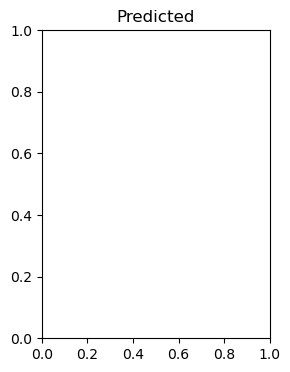